# SVM

## Cargamos Librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.preprocessing import normalize, scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, atpe
from mlxtend.plotting import plot_decision_regions
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module" or "once"

### Subset para el cálculo de los Hiperparámetros

In [2]:
calculo_hiper = pd.read_csv("train.csv")

### Muestra Aleatoria Simple al 80%  recursos máquina

In [3]:
random=calculo_hiper.sample(frac=0.8, replace=True, random_state=1)

### Definimos el Target 1/0 en función de la variable Precio

In [4]:
random['target'] = np.where(random['price']>645000, 1, 0)

### Tratamiento con las Variables Categóricas.
#### Primero realizamos una agrupación de las Variables Categóricas con muchos Grados de Libertad 

In [5]:
pre_calculo_hiper = random [['target','floors','yr_built','yr_renovated','view','bedrooms','bathrooms',"sqft_living", "sqft_lot", "sqft_living15" , "sqft_lot15",  "sqft_above" ,"sqft_basement",'Cluster_final','condition','grade']]

#### Segundo una vez agrupadas las Transformamos a Dummy para poder trabajar con las SVM

In [6]:
d_pre_calculo_hiper=pd.get_dummies(pre_calculo_hiper, columns=['Cluster_final'])

In [7]:
X = d_pre_calculo_hiper.drop('target', axis=1)
y = d_pre_calculo_hiper['target']

### Lanzámos la Búsqueda de los Hiperparámetros óptimos para Nuestra Muestra de Entrenamiento del 80% sobre la población Train

## Hiperparámetros para la SVM

In [8]:
from sklearn.svm import SVC
def hyperopt_train_test(params):
    X_ = X[:]
    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
        del params['normalize']
    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
        del params['scale']
    clf = SVC(**params)
    return round(cross_val_score(clf, X_, y).mean(),2)

space4svm = {
    'C': hp.uniform('C', 0, 10),
    'kernel': hp.choice('kernel', ['linear', 'sigmoid', 'poly', 'rbf']),
    'gamma': hp.uniform('gamma', 0, 10),
    'scale': hp.choice('scale', [0, 1]),
    'normalize': hp.choice('normalize', [0, 1])
}

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4svm, algo=atpe.suggest, max_evals=10, trials=trials)
print('best:{}'.format(best))


100%|██████████| 10/10 [38:00<00:00, 228.10s/trial, best loss: -0.89]
best:{'C': 3.335718952897629, 'gamma': 7.465125478667083, 'kernel': 2, 'normalize': 1, 'scale': 1}


### Los parámetros Optenidos son 'C': 3.3 ;'kernel': 'Poly'

### Realizamos un PCA y realizamos una visualización simple en un plano de nuestra Submuestra con la SVM parametrizada con los datos anteriores.

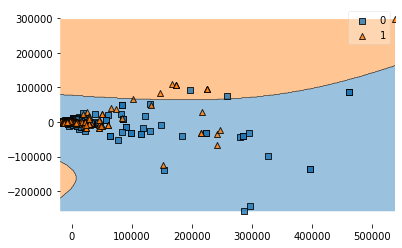

In [8]:
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
myarray = np.asarray(y)

clf = SVC(C=3.3, kernel='poly',gamma='scale',coef0=1)
clf.fit(principalComponents,y)

plot_decision_regions(X=principalComponents, y=myarray, clf=clf);

### Aparanentemente no funciona demasiado bien, probaremos con los parametros dentro de nuestra pobación de Train y validacion

#### En el tratamiento previo de Datos seguiremos en mismo proceso que anteriormente

In [9]:
cluster = pd.read_csv("train.csv")
validation= pd.read_csv("validation.csv")

In [10]:
cluster['target'] = np.where(cluster['price']>645000, 1, 0)
validation['target'] = np.where(validation['price']>645000, 1, 0)

In [11]:
precluster = cluster [['target','floors','yr_built','yr_renovated','view','bedrooms','bathrooms',"sqft_living", "sqft_lot", "sqft_living15" , "sqft_lot15",  "sqft_above" ,"sqft_basement",'Cluster_final','condition','grade']]
prevalidation = validation [['target','floors','yr_built','yr_renovated','view','bedrooms','bathrooms',"sqft_living", "sqft_lot", "sqft_living15" , "sqft_lot15",  "sqft_above" ,"sqft_basement",'Cluster_final','condition','grade']]

In [12]:
d_precluster=pd.get_dummies(precluster, columns=['Cluster_final'])
d_prevalidation=pd.get_dummies(prevalidation, columns=['Cluster_final'])

In [13]:
X_train = d_precluster.drop('target', axis=1)
y_train = d_precluster['target']
X_test= d_prevalidation.drop('target', axis=1)
y_test= d_prevalidation['target']

In [14]:
X_train = normalize(X_train, axis=0)
X_test  = normalize(X_test, axis=0)

## Después de varias pruebas, la mejor parametrización que encontramos para la maximización del Accuracy es con C=1 y no con C=3.3 tal y como nos sugería el cálculo previo. Queda lejos de nuestro mejor modelo.

In [15]:
clf = SVC(C=1, kernel='poly',gamma='scale',coef0=0)
clf.fit(X_train, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [16]:
y_pred=clf.predict(X_test)

In [17]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[2953  291]
 [ 246  830]]
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      3244
           1       0.74      0.77      0.76      1076

    accuracy                           0.88      4320
   macro avg       0.83      0.84      0.84      4320
weighted avg       0.88      0.88      0.88      4320



### la medida que estamos analizando es el Accuracy y es de 0.88. No es un mal resultado pero pensabamos que íbamos a obtener mejores resultados

In [18]:
y_pred.tolist()
y_test.tolist()
salida = pd.DataFrame(
    {'y_test': y_test,
     'y_pred': y_pred
    })

In [19]:
salida.to_csv('salida.csv')

In [20]:
from sklearn.calibration import CalibratedClassifierCV
model = CalibratedClassifierCV(clf) 
model.fit(X_train, y_train)

C:\Users\Pablo\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


CalibratedClassifierCV(base_estimator=SVC(C=1, break_ties=False, cache_size=200,
                                          class_weight=None, coef0=0,
                                          decision_function_shape='ovr',
                                          degree=3, gamma='scale',
                                          kernel='poly', max_iter=-1,
                                          probability=False, random_state=None,
                                          shrinking=True, tol=0.001,
                                          verbose=False),
                       cv=None, method='sigmoid')

C:\Users\Pablo\Anaconda3\lib\site-packages\scikitplot\plotters.py:37: DeprecationWarning: This module was deprecated in version 0.3.0 and its functions are spread throughout different modules. Please check the documentation and update your function calls as soon as possible. This module will be removed in 0.4.0
  DeprecationWarning)


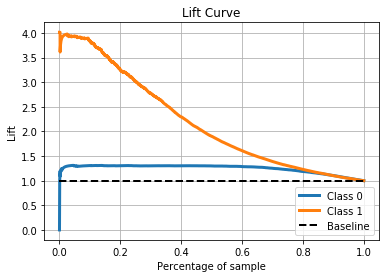

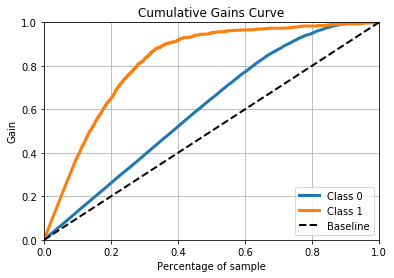

C:\Users\Pablo\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Pablo\Anaconda3\lib\site-packages\scikitplot\metrics.py:284: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])
C:\Users\Pablo\Anaconda3\lib\site-packages\scikitplot\metrics.py:284: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


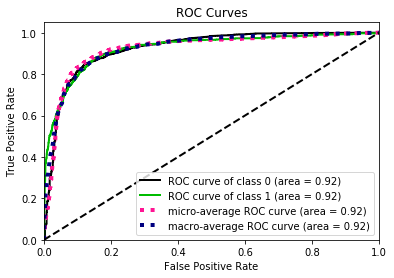

In [21]:
import matplotlib.pyplot as plt
import scikitplot as skplt
Y_test_pred_ = model.predict_proba(X_test)[:]
skplt.metrics.plot_lift_curve(y_test, Y_test_pred_)
plt.show()
skplt.metrics.plot_cumulative_gain(y_test, Y_test_pred_)
plt.show()
skplt.metrics.plot_roc_curve(y_test, Y_test_pred_)
plt.show()